In [1]:
import os
import json
import random

from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from layers import linear_forward, linear_backward, relu_forward, relu_backward, cross_entropy_loss, NeuralNetwork
from utils import check_gradient


%load_ext autoreload
%autoreload 2

C:\Users\baska\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing

In [48]:
# Change these as per your dataset structure

dataset_path = "dataset/train" 
labels_path ='train_labels.json'

In [49]:
def process_img(img_path: str) -> np.ndarray:
    """Reads the image from the given path and returns it as a flattened numpy array

    Args:
        img_path (str): path to the image

    Returns:
        np.ndarray: flattened image
    """


    # Read as a numpy array of shape (28, 28)
    img = mpimg.imread(img_path)

    # Flatten the image
    img = img.reshape(-1)
    
    return img

In [50]:
data = [] # Stores a tuple of (img, label)

# Load the labels from the json file
label_mapping = json.load(open(labels_path, 'r'))

for img_name in tqdm(os.listdir(dataset_path)):

    # Get the image path and read the image
    img_path = os.path.join(dataset_path, img_name)
    img = process_img(img_path)

    
    # Label is the digit in the image
    label = label_mapping[img_name[:-4]]
    
    data.append((img, label))

100%|██████████| 60000/60000 [00:21<00:00, 2748.98it/s]


In [57]:
# Split the training data into train and validation sets
NUM_VALIDATION_SAMPLES = 5

train_data = data[:-NUM_VALIDATION_SAMPLES]
val_data = data[-NUM_VALIDATION_SAMPLES:]

print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")

# Split the data into images and labels
train_imgs, train_labels = zip(*train_data)
val_imgs, val_labels = zip(*val_data)

# Convert the data into numpy arrays
train_imgs = np.array(train_imgs)
train_labels = np.array(train_labels)

val_imgs = np.array(val_imgs)
val_labels = np.array(val_labels)

Number of training samples: 59995
Number of validation samples: 5


## Neural Network Layers

### **Linear Layer**

In [58]:
# Checking gradient calculations for linear layer

x = np.random.randn(10, 5)
w = np.random.randn(5, 3)
b = np.random.randn(3)
dout = np.random.randn(10, 3)

_, cache = linear_forward(x, w, b)
dx, dw, db = linear_backward(dout, cache)

print('dx error: ', check_gradient(lambda x: linear_forward(x, w, b)[0], x, dout, dx))
print('dw error: ', check_gradient(lambda w: linear_forward(x, w, b)[0], w, dout, dw))
print('db error: ', check_gradient(lambda b: linear_forward(x, w, b)[0], b, dout, db))

dx error:  5.245762560401367e-10
dw error:  2.8449924554679108e-11
db error:  8.858354471494841e-12


### **ReLU Layer**

In [59]:
# Checking gradient calculations for relu layer

x = np.random.randn(10, 5)
dout = np.random.randn(*x.shape)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

print('dx error: ', check_gradient(lambda x: relu_forward(x)[0], x, dout, dx))

dx error:  3.275618449887663e-12


### **Cross Entropy Loss**

In [60]:
# Checking gradient calculations for cross entropy loss

x = np.random.randn(10, 5)
y = np.random.randint(5, size=10)

loss, dx = cross_entropy_loss(x, y)

print('dx error: ', check_gradient(lambda x: cross_entropy_loss(x, y)[0], x, 1.0, dx))

dx error:  3.727346021290315e-09


## Neural Network Architecture

In [140]:
# Let's first set our hyperparameters

NUM_EPOCHS = 500
LEARNING_RATE = 0.15
HIDDEN_LAYERS = [30,30,30,30]

# Initialize our Neural Network
model = NeuralNetwork(hidden_dims=HIDDEN_LAYERS)

In [142]:
# Train our model and store the metrics for plotting
# History is a dictionary that stores the loss and accuracy for each epoch
history = {
    'Loss': [],
    'Accuracy': []
}

# To display the progress bar
progress_bar = tqdm(total=NUM_EPOCHS)
for epoch in range(NUM_EPOCHS):

    # Forward pass
    logits, cache = model.forward(train_imgs)

    # Take the argmax of the logits to get the predicted labels and calculate the accuracy.
    preds = np.argmax(logits, axis=1)
    accuracy = np.mean(preds == train_labels)

    # Calculate the loss and the gradients through backpropagation.
    loss, dout = cross_entropy_loss(logits, train_labels)
    grads = model.backward(dout, cache)

    # Update the model parameters
    model.update(grads, LEARNING_RATE)

    # Update the progress bar and record the metrics
    progress_bar.update()
    progress_bar.set_postfix({'Epoch': epoch+1, 'Loss': loss, 'Accuracy': accuracy})
    history['Accuracy'].append(accuracy)
    history['Loss'].append(loss)

100%|██████████| 500/500 [10:54<00:00,  1.22s/it, Epoch=500, Loss=0.159, Accuracy=0.952]

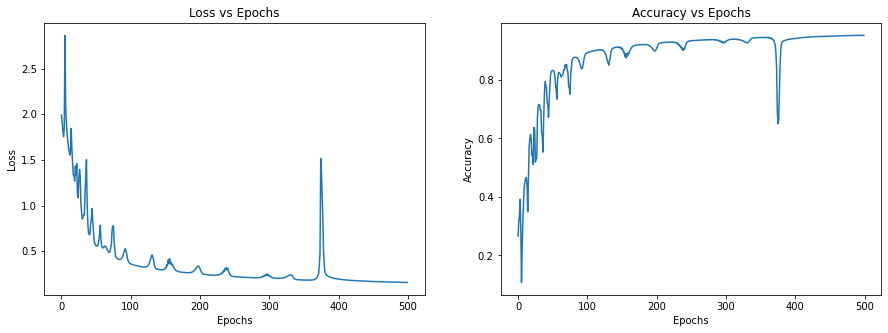

In [143]:
# Plot the loss and accuracy for each epoch
_, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['Loss'])
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss vs Epochs')

axes[1].plot(history['Accuracy'])
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy vs Epochs')

plt.show()

## Predictions on the test set

In [144]:
# Load the test data

test_data = [] # Stores a tuple of (img, img_name)

test_dataset_path = "dataset/test/test"#os.path.join('dataset', 'test')

for img_name in tqdm(os.listdir(test_dataset_path)):
        
    # Get the image path and read the image
    img_path = os.path.join(test_dataset_path, img_name)
    img = process_img(img_path)
    
    
    test_data.append((img, int(img_name[:-4])))

# Split the data into images and ids
test_imgs, test_ids = zip(*test_data)

# Convert the data into numpy arrays
test_imgs = np.array(test_imgs)

100%|██████████| 10000/10000 [00:04<00:00, 2266.66it/s]


In [145]:
# Get the predictions for the test data

test_predictions = None

test_logits, _ = model.forward(test_imgs)
test_predictions = np.argmax(test_logits, axis=1).tolist()
test_predictions

[1,
 3,
 6,
 2,
 6,
 9,
 4,
 9,
 4,
 0,
 6,
 0,
 2,
 7,
 6,
 0,
 1,
 6,
 3,
 6,
 4,
 4,
 4,
 8,
 8,
 2,
 7,
 9,
 2,
 5,
 3,
 9,
 1,
 2,
 4,
 3,
 9,
 1,
 3,
 0,
 3,
 9,
 9,
 7,
 0,
 3,
 9,
 3,
 1,
 4,
 3,
 0,
 6,
 8,
 4,
 4,
 7,
 8,
 1,
 1,
 4,
 8,
 1,
 5,
 6,
 0,
 0,
 1,
 0,
 7,
 5,
 2,
 3,
 3,
 9,
 6,
 0,
 3,
 1,
 2,
 8,
 5,
 1,
 5,
 0,
 4,
 1,
 4,
 0,
 3,
 4,
 9,
 7,
 9,
 1,
 9,
 7,
 4,
 6,
 1,
 7,
 5,
 5,
 2,
 1,
 7,
 9,
 3,
 0,
 6,
 6,
 7,
 8,
 2,
 4,
 8,
 2,
 6,
 7,
 4,
 1,
 3,
 0,
 5,
 5,
 7,
 6,
 0,
 6,
 1,
 5,
 6,
 5,
 5,
 8,
 3,
 3,
 4,
 9,
 1,
 2,
 4,
 1,
 5,
 2,
 9,
 2,
 8,
 1,
 4,
 2,
 5,
 0,
 6,
 4,
 1,
 0,
 8,
 5,
 7,
 5,
 2,
 8,
 6,
 1,
 6,
 4,
 0,
 9,
 6,
 2,
 4,
 2,
 5,
 2,
 8,
 3,
 5,
 7,
 6,
 9,
 4,
 3,
 7,
 4,
 7,
 8,
 8,
 8,
 8,
 7,
 8,
 6,
 5,
 6,
 0,
 4,
 5,
 7,
 7,
 6,
 7,
 9,
 3,
 7,
 5,
 0,
 9,
 5,
 0,
 1,
 2,
 9,
 4,
 7,
 7,
 9,
 5,
 2,
 7,
 8,
 0,
 0,
 6,
 8,
 6,
 2,
 7,
 7,
 5,
 3,
 3,
 1,
 2,
 1,
 6,
 2,
 5,
 4,
 3,
 3,
 7,
 2,
 0,
 0,
 2,
 3,
 9,
 1,
 1,


Checking If the Outputs are Correct

In [146]:
# Some assertions on the predictions

assert len(test_predictions) == len(test_ids), "Incorrect number of predictions in the test set"
assert set(test_predictions).issubset(set(range(10))), "Some of the predicted classes are incorrect"